# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print (f"Azdias: {azdias.shape}")
azdias.head()

Azdias: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [4]:
print (f"Feature Summary: {feat_info.shape}")
feat_info

Feature Summary: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
# Find the number of entries with null values.
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [6]:
# Deal with the X's...
for index in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[index]["missing_or_unknown"]
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias_clean = azdias.replace({feat_info.iloc[index]["attribute"]: missing_or_unknown}, np.nan)

for col in azdias.columns:
    azdias_clean = azdias_clean.replace({col: ["XX", "X"]}, np.nan)
feat_info["missing_or_unknown"]


0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [7]:
# Check it!
azdias_clean.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

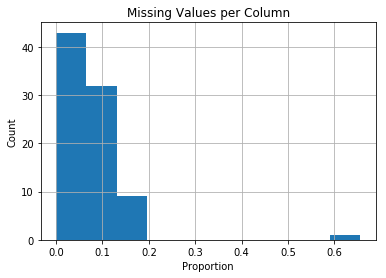

In [8]:
# Graph it.  How much missing data is there?
# want proportion of total number of null values per column.
proportion = azdias_clean.isnull().sum() / azdias_clean.shape[0]
proportion.hist()
plt.xlabel("Proportion")
plt.ylabel("Count")
plt.title("Missing Values per Column")
plt.show()

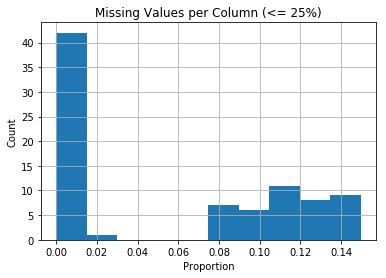

In [9]:
# It looks like the interesting stuff is below 0.25 (or 25%)
# Check out the graph and see what is going on.
proportion_25 = proportion[proportion <= 0.25]
proportion_25.hist()
plt.xlabel("Proportion")
plt.ylabel("Count")
plt.title("Missing Values per Column (<= 25%)")
plt.show()

In [10]:
# It looks like a nice distribution centered around 0.11ish.  
# This would indicate that anything above 0.25 is an outlier and should be removed.
# But what are these outliers?
outliers = proportion[proportion > 0.2].index
azdias_no_outliers = azdias_clean.drop(outliers, axis = 1)
outliers

Index(['KK_KUNDENTYP'], dtype='object')

In [11]:
azdias_no_outliers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column
The x-axis in the first graph has a range from 0 to 1.0.  Of that range, the missing data is found beyond 0.25.  This means that the missing data is skewed to the right.  Interestingly, of the available data seen in the second graph, there appears to be a fairly normal distribution that ranges from ~0.075 to ~0.175.

The column with missing values, found outside of the 0.25 cut off include:
    1. KK_KUNDENTYP

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
# First line is total rows.  Anything less than that value indicates that there are missing values

print (len(azdias_no_outliers))
print (azdias_no_outliers.count())

891221
AGER_TYP                 891221
ALTERSKATEGORIE_GROB     891221
ANREDE_KZ                891221
CJT_GESAMTTYP            886367
FINANZ_MINIMALIST        891221
FINANZ_SPARER            891221
FINANZ_VORSORGER         891221
FINANZ_ANLEGER           891221
FINANZ_UNAUFFAELLIGER    891221
FINANZ_HAUSBAUER         891221
FINANZTYP                891221
GEBURTSJAHR              891221
GFK_URLAUBERTYP          886367
GREEN_AVANTGARDE         891221
HEALTH_TYP               891221
LP_LEBENSPHASE_FEIN      886367
LP_LEBENSPHASE_GROB      886367
LP_FAMILIE_FEIN          886367
LP_FAMILIE_GROB          886367
LP_STATUS_FEIN           886367
LP_STATUS_GROB           886367
NATIONALITAET_KZ         891221
PRAEGENDE_JUGENDJAHRE    891221
RETOURTYP_BK_S           886367
SEMIO_SOZ                891221
SEMIO_FAM                891221
SEMIO_REL                891221
SEMIO_MAT                891221
SEMIO_VERT               891221
SEMIO_LUST               891221
                          ...  
O

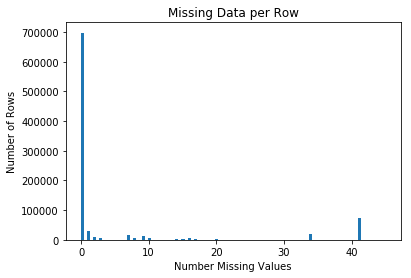

In [13]:
# Graph the data that is missing per row.
missing_rows = azdias_no_outliers.isnull().sum(axis = 1)
plt.hist(missing_rows, bins = 100)
plt.xlabel("Number Missing Values")
plt.ylabel("Number of Rows")
plt.title("Missing Data per Row")
plt.show()

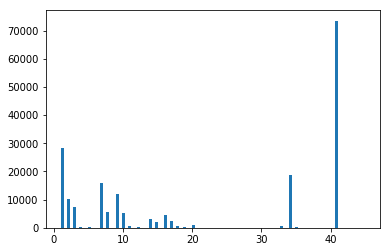

In [14]:
# Take a closer look!
missing_rows_zoom = missing_rows[missing_rows > 0]
plt.hist(missing_rows_zoom, bins = 100)
plt.show()

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_lt3 = azdias_no_outliers[azdias_no_outliers.isnull().sum(axis = 1) <= 20]
azdias_gt3 = azdias_no_outliers[azdias_no_outliers.isnull().sum(axis = 1) > 20]

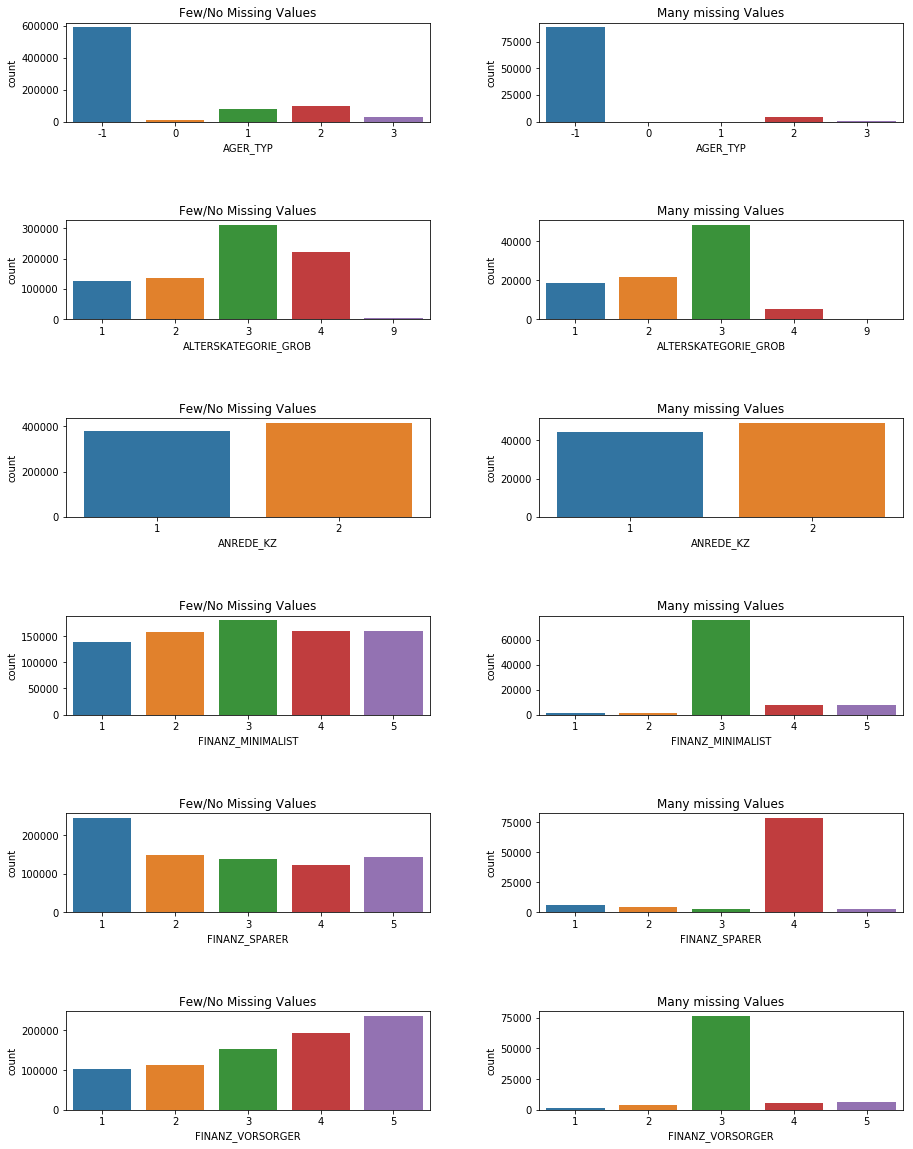

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
zeros = proportion[proportion==0].index.tolist()
compare_columns = zeros[:6]
figure, axs = plt.subplots(nrows = len(compare_columns), ncols = 2, figsize = (15, 20))
figure.subplots_adjust(hspace = 1, wspace = 0.3)

for i in range(len(compare_columns)):
    sns.countplot(azdias_lt3[compare_columns[i]], ax = axs[i][0])
    axs[i][0].set_title("Few/No Missing Values")
    sns.countplot(azdias_gt3[compare_columns[i]], ax = axs[i][1])
    axs[i][1].set_title("Many missing Values")



#### Discussion 1.1.3: Assess Missing Data in Each Row

Some of the financial features vary between the two types (few/no v. many missing values).  See graphs.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
features = list(azdias_lt3.columns)
feat_info_clean = feat_info[feat_info["attribute"].isin(features)]
data_type_count = feat_info_clean["type"].value_counts()
data_type_count

ordinal        49
categorical    20
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
category_features = feat_info_clean[feat_info_clean["type"] == "categorical"]["attribute"]

In [19]:
# Separate the categoricals into either binary or multi features.
binary_features = []
multi_features = []

for feature in category_features:
    if (len(azdias_lt3[feature].unique())==2):
        binary_features.append(feature)
    else:
        multi_features.append(feature)
print (binary_features)
print ("------------")
print (multi_features)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
------------
['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [20]:
# Print out what the binary_features are.
for thing in binary_features:
    print (thing, azdias_lt3[thing].unique())

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ ['W' 'O']


In [21]:
# Since the OST_WEST_KZ has alpha instead of numeric, need to re-encode it.
new_vals = {"W": 0, "O": 1}
azdias_clean = azdias_lt3.replace({"OST_WEST_KZ": new_vals})

In [22]:
# Great.  Get rid of the multi_features from the category_features.
for feature in multi_features:
    azdias_clean = azdias_clean.drop(feature, axis = 1)

In [23]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1,2,1,5,2,5,4,5,1996,0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3,2,1,4,1,2,3,5,1979,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4,2,4,2,5,2,1,2,1957,0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3,1,4,3,4,1,3,2,1963,0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1,2,3,1,5,2,2,5,1943,0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

1. Drop the multi level features.
2. Keep all binary features.  These include: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ.
3. Re-encode the OST_WEST_KZ, swapping out the strings to numbers for downstream analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean["decade"] = azdias_clean["PRAEGENDE_JUGENDJAHRE"]
azdias_clean["movement"] = azdias_clean["PRAEGENDE_JUGENDJAHRE"]

main1 = azdias_clean["PRAEGENDE_JUGENDJAHRE"].isin([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
main2 = azdias_clean["PRAEGENDE_JUGENDJAHRE"].isin([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])

azdias_clean.loc[main1, "movement"] = 1.0
azdias_clean.loc[main2, "movement"] = 2.0

In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
if azdias_clean["CAMEO_INTL_2015"].dtype == "float64":
    azdias_clean["wealth"] = azdias_clean["CAMEO_INTL_2015"] // 10
    azdias_clean["life_stage"] = azdias_clean["CAMEO_INTL_2015"] % 10
else:
    azdias_clean["wealth"] = azdias_clean["CAMEO_INTL_2015"].str[0].astype("float")
    azdias_clean["life_stage"] = azdias_clean["CAMEO_INTL_2015"].str[1].astype("float")

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are two mixed value features that were worked on: PRAEGENDE_JUGENDJAHRE, and CAMEO_INTL_2015.  To deal with this, for each feature, two columns were created.  Dictionaries were created to do new feature values.  The dictionary values replaced the mixed value features  But I thought about it some more and foudn that I could use math for CAMEO_INTL_2015.  Much better--no dictionary for that one.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [26]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [27]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Since I have new columns for the mixed features...  I would like to drop
# the mixed feature columns.
mixed_features = feat_info_clean[feat_info_clean["type"] == "mixed"]["attribute"]
for thing in mixed_features:
    azdias_clean.drop(thing, axis = 1, inplace = True)
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1,2,1,5,2,5,4,5,1996,0,...,1.0,5.0,4.0,3.0,5.0,4.0,14,1.0,5.0,1.0
2,3,2,1,4,1,2,3,5,1979,1,...,0.0,4.0,4.0,3.0,5.0,2.0,15,2.0,2.0,4.0
3,4,2,4,2,5,2,1,2,1957,0,...,0.0,3.0,4.0,2.0,3.0,3.0,8,1.0,1.0,2.0
4,3,1,4,3,4,1,3,2,1963,0,...,1.0,3.0,3.0,4.0,6.0,5.0,8,1.0,4.0,3.0
5,1,2,3,1,5,2,2,5,1943,0,...,1.0,5.0,5.0,2.0,3.0,3.0,3,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [28]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for index in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[index]["missing_or_unknown"]
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_clean = df.replace({feat_info.iloc[index]["attribute"]: missing_or_unknown}, np.nan)
    
    for col in df_clean.columns:
        df_clean = df_clean.replace({col: ["XX", "X"]}, np.nan)
    
    columns_miss = ['KK_KUNDENTYP']
    df_clean = df_clean.drop(columns_miss, axis=1)
    df_clean = df_clean[df_clean.isnull().sum(axis = 1) <= 20]
    
    new_vals = {"W": 0, "O": 1}
    df_clean = df_clean.replace({"OST_WEST_KZ": new_vals})
    
    features = list(df_clean.columns)
    feat_info_clean = feat_info[feat_info["attribute"].isin(features)]
    category_features = feat_info_clean[feat_info_clean["type"] == "categorical"]["attribute"]
    
    binary_features = []
    multi_features = []
    for feature in category_features:
        if (len(df_clean[feature].unique())==2):
            binary_features.append(feature)
        else:
            multi_features.append(feature)
    
    for feature in multi_features:
        df_clean = df_clean.drop(feature, axis = 1)
    
    df_clean["decade"] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean["movement"] = df_clean['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df_clean["decade"].replace(decade_dict, inplace=True)
    df_clean["movement"].replace(movement_dict, inplace=True)

    if df_clean["CAMEO_INTL_2015"].dtype == "float64":
        df_clean["wealth"] = df_clean["CAMEO_INTL_2015"] // 10
        df_clean["life_stage"] = df_clean["CAMEO_INTL_2015"] % 10
    else:
        df_clean["wealth"] = df_clean["CAMEO_INTL_2015"].str[0].astype("float")
        df_clean["life_stage"] = df_clean["CAMEO_INTL_2015"].str[1].astype("float")

    mixed_features = feat_info_clean[feat_info_clean["type"] == "mixed"]["attribute"]
    for thing in mixed_features:
        df_clean.drop(thing, axis = 1, inplace = True)
    
    return df_clean


In [29]:
# Import the same azdias file and try the function.  Test to make sure it's same.
azdias1 = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")
test = clean_data(azdias1)

In [30]:
# This better be true.
azdias_clean.shape == test.shape

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_fin = azdias_clean.dropna(how = "any")
azdias_fin.count()

ALTERSKATEGORIE_GROB     697537
ANREDE_KZ                697537
FINANZ_MINIMALIST        697537
FINANZ_SPARER            697537
FINANZ_VORSORGER         697537
FINANZ_ANLEGER           697537
FINANZ_UNAUFFAELLIGER    697537
FINANZ_HAUSBAUER         697537
GEBURTSJAHR              697537
GREEN_AVANTGARDE         697537
HEALTH_TYP               697537
RETOURTYP_BK_S           697537
SEMIO_SOZ                697537
SEMIO_FAM                697537
SEMIO_REL                697537
SEMIO_MAT                697537
SEMIO_VERT               697537
SEMIO_LUST               697537
SEMIO_ERL                697537
SEMIO_KULT               697537
SEMIO_RAT                697537
SEMIO_KRIT               697537
SEMIO_DOM                697537
SEMIO_KAEM               697537
SEMIO_PFLICHT            697537
SEMIO_TRADV              697537
SOHO_KZ                  697537
ALTER_HH                 697537
ANZ_PERSONEN             697537
ANZ_TITEL                697537
                          ...  
KONSUMNA

In [32]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_fin)

azdias_scaled = pd.DataFrame(azdias_scaled, columns = list(azdias_fin))
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,-1.682267,0.956254,-1.466835,1.526679,-1.044670,1.466122,1.005857,1.306196,0.836378,-0.533797,...,0.389823,1.428970,0.573271,-0.189875,-0.153563,0.665038,1.182315,-0.401943,1.157341,-1.247213
1,0.169436,0.956254,-1.466835,0.856558,-1.770674,-0.568593,0.285667,1.306196,0.818691,1.873371,...,-0.979527,0.395011,0.573271,-0.189875,-0.153563,-0.810638,1.416071,1.731786,-0.888324,0.757733
2,0.169436,-1.045747,0.712590,0.186437,0.407338,-1.246831,0.285667,-0.869700,0.802044,-0.533797,...,0.389823,-0.638948,-0.325210,0.818973,0.281936,1.402876,-0.220219,-0.401943,0.475453,0.089417
3,-1.682267,0.956254,-0.013885,-1.153804,1.133342,-0.568593,-0.434522,1.306196,0.781235,-0.533797,...,0.389823,1.428970,1.471752,-1.198722,-1.024561,-0.072800,-1.388998,-0.401943,1.157341,0.757733
4,-0.756416,0.956254,-1.466835,1.526679,-1.770674,1.466122,1.005857,-0.144401,-1.240334,-0.533797,...,-0.979527,1.428970,1.471752,0.818973,0.281936,-0.072800,0.247292,-0.401943,-0.888324,-0.578898


### Discussion 2.1: Apply Feature Scaling

I dropped the rows that had any remaining NaN values and confirmed it via count.  Then, I scaled the data and shoved it into a dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

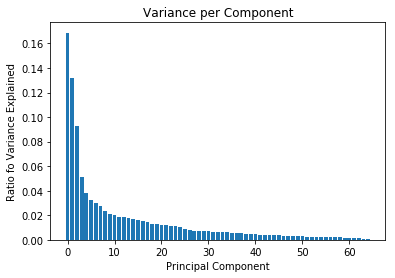

In [34]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Ratio fo Variance Explained")
plt.title("Variance per Component")
plt.show()

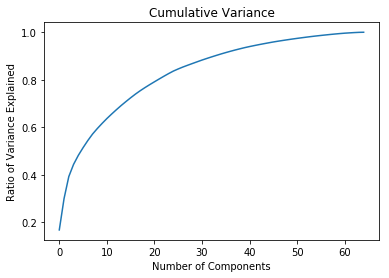

In [35]:
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), "-")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of Variance Explained")
plt.title("Cumulative Variance")
plt.show()

In [36]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30 = PCA(n_components = 30)
azdias_pca = pca_30.fit_transform(azdias_scaled)

In [37]:
sum(pca_30.explained_variance_ratio_)

0.87566662704454457

### Discussion 2.2: Perform Dimensionality Reduction

I retined 30 principal components--it accounts for ~88% variances while reducing the number fo features by more than 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights_pca(pca, i):
    df = pd.DataFrame(pca.components_, columns = list(azdias_scaled.columns))
    weights = df.iloc[i].sort_values(ascending = False)
    return weights


In [39]:
weights_pca_0 = weights_pca(pca_30, 0)
print (weights_pca_0)

PLZ8_ANTG3               0.229388
PLZ8_ANTG4               0.222203
wealth                   0.210540
HH_EINKOMMEN_SCORE       0.205771
ORTSGR_KLS9              0.200449
EWDICHTE                 0.198083
FINANZ_HAUSBAUER         0.166333
KBA05_ANTG4              0.156583
PLZ8_ANTG2               0.154319
ARBEIT                   0.146609
ANZ_HAUSHALTE_AKTIV      0.139616
KBA05_ANTG3              0.137355
RELAT_AB                 0.136945
FINANZ_SPARER            0.134575
SEMIO_PFLICHT            0.103709
SEMIO_REL                0.100251
REGIOTYP                 0.087713
SEMIO_RAT                0.087187
SEMIO_MAT                0.076210
SEMIO_TRADV              0.075870
SEMIO_FAM                0.071246
FINANZ_UNAUFFAELLIGER    0.067074
KKK                      0.062920
decade                   0.061769
SEMIO_KULT               0.061259
FINANZ_ANLEGER           0.059416
OST_WEST_KZ              0.056625
SEMIO_KAEM               0.043134
PLZ8_HHZ                 0.040622
ANZ_HH_TITEL  

In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pca_1 = weights_pca(pca_30, 1)
print (weights_pca_1)

ALTERSKATEGORIE_GROB     0.252886
SEMIO_ERL                0.238266
FINANZ_VORSORGER         0.237722
SEMIO_LUST               0.184085
RETOURTYP_BK_S           0.167596
SEMIO_KRIT               0.124340
W_KEIT_KIND_HH           0.115692
SEMIO_KAEM               0.113355
FINANZ_HAUSBAUER         0.105645
ANREDE_KZ                0.095141
FINANZ_MINIMALIST        0.076552
PLZ8_ANTG3               0.075584
EWDICHTE                 0.074348
ORTSGR_KLS9              0.072929
PLZ8_ANTG4               0.072030
SEMIO_DOM                0.069664
WOHNDAUER_2008           0.065202
KBA05_ANTG4              0.059517
wealth                   0.059422
ARBEIT                   0.054771
RELAT_AB                 0.053220
ANZ_HAUSHALTE_AKTIV      0.051415
PLZ8_ANTG2               0.051199
HH_EINKOMMEN_SCORE       0.041116
KBA05_ANTG3              0.035386
REGIOTYP                 0.031064
ANZ_HH_TITEL             0.027349
OST_WEST_KZ              0.020867
KKK                      0.018710
PLZ8_HHZ      

In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_pca_2 = weights_pca(pca_30, 2)
print (weights_pca_2)

SEMIO_VERT               0.347093
SEMIO_SOZ                0.263168
SEMIO_FAM                0.244404
SEMIO_KULT               0.226394
FINANZ_MINIMALIST        0.161697
RETOURTYP_BK_S           0.114272
FINANZ_VORSORGER         0.105880
W_KEIT_KIND_HH           0.100393
ALTERSKATEGORIE_GROB     0.079842
SEMIO_LUST               0.064582
SEMIO_REL                0.060679
movement                 0.051657
GREEN_AVANTGARDE         0.047561
ORTSGR_KLS9              0.046831
EWDICHTE                 0.046327
SEMIO_MAT                0.046204
PLZ8_ANTG4               0.045971
PLZ8_ANTG3               0.045352
WOHNDAUER_2008           0.036087
ARBEIT                   0.034521
RELAT_AB                 0.031628
PLZ8_ANTG2               0.029431
KBA05_ANTG4              0.029153
wealth                   0.027290
ANZ_HAUSHALTE_AKTIV      0.026165
HEALTH_TYP               0.022420
OST_WEST_KZ              0.015257
ANZ_HH_TITEL             0.014084
ANZ_TITEL                0.010063
KBA05_ANTG3   

### Discussion 2.3: Interpret Principal Components

FIRST PCA COMPONENT.
- PLZ8_ANTG3 and PLZ8_ANTG4 have a positive correlation.  This is looking at 10+ family homes and 6-10 family homes.  The positive correlation means that they tend to increase together.

- PLZ8_ANTG4 and wealth have a positive correlation.  It indicates that as a 6-10 family home increases, the wealth tends to have poorer hoseholds.  (This makes sense as there is less income to be distributed.)

- MOBI_REGIO and PLZ8_ANTG3 have a negative correlation.  This means that as a 6-10 family home increases, it tends to have less movement.  I think....

SECOND PCA COMPONENT.
- ALTERSKATEGORIE_GROB evaluates age as FINANZ_VORSORGER is financial preparedness.  Both have positive correleation...the way I read this is that as age increases, likelyhood of being financially prepared for any acute financial hardship increases.
- SEMIO_REL has a negative correlation.  So I guess that means as you age and become more financially well off, you become less religious (!).  However, I wonder the trends reverse themselves as health declines, regardless of age....

THIRD PCA COMPONENT.
- SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM all correspond to being a dreamer, and more socially minded.  These have positive correlation and they are tied to each other.  Additionally, it is interesting to note that FINANZ_MINIMALIST is also positively correlated.  THat would mean that the dreamers are not good with financial investments. 
- Gender (ANREDE_KZ) has a negative correlation.  The way I read that is that the previously mentioned traits happen regardless of gender.  They are gender blind.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [43]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
ks = list(range(1, 20))
for k in ks:
    scores.append(k_mean_score(azdias_pca, k)) 

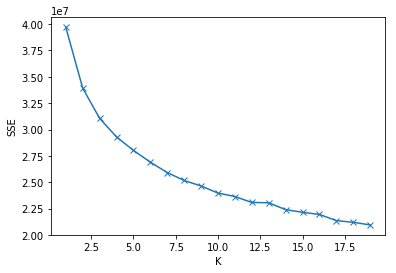

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(ks, scores, marker= "x")
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()


In [45]:
scores

[39702641.681870088,
 33922572.519103155,
 31060211.202293128,
 29289754.87218076,
 28020245.507251117,
 26895889.005792834,
 25916634.886015788,
 25161481.537369523,
 24641438.703804016,
 23968116.412418522,
 23642656.342660919,
 23077920.663107011,
 23047422.045242272,
 22395837.135109529,
 22142533.983119473,
 21940101.546248481,
 21355734.866251044,
 21195596.237471726,
 20946768.321753565]

In [46]:
ks

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [47]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 14)
model_12 = kmeans.fit(azdias_pca)
azdias_prediction = model_12.predict(azdias_pca)

In [48]:
azdias_prediction

array([4, 3, 2, ..., 5, 9, 2], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

Looking at the above plot and the numbers...  It looks like the elbow is at 14.  Therefore, decided to use 14 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [49]:
# Load in the customer demographics data.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

print (f"customers: {customers.shape}")
customers.head()

customers: (191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [50]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

In [51]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
0,4,1,5,1,5,1,2,2,0,1,...,0.0,5.0,5.0,1.0,2.0,1.0,2,0,1.0,3.0
2,4,2,5,1,5,1,4,4,0,1,...,1.0,3.0,2.0,3.0,5.0,3.0,2,0,3.0,4.0
3,4,1,5,1,5,2,1,2,0,0,...,0.0,3.0,4.0,1.0,3.0,1.0,1,1,2.0,4.0
4,3,1,3,1,4,4,5,2,1960,0,...,1.0,3.0,3.0,3.0,5.0,1.0,4,1,4.0,1.0
5,3,1,5,1,5,1,2,3,0,1,...,1.0,5.0,5.0,3.0,7.0,5.0,2,0,3.0,4.0


In [52]:
# Get rid of leftover Nans.
customers_fin = customers_clean.dropna(how = "any")
customers_fin.count()

ALTERSKATEGORIE_GROB     123187
ANREDE_KZ                123187
FINANZ_MINIMALIST        123187
FINANZ_SPARER            123187
FINANZ_VORSORGER         123187
FINANZ_ANLEGER           123187
FINANZ_UNAUFFAELLIGER    123187
FINANZ_HAUSBAUER         123187
GEBURTSJAHR              123187
GREEN_AVANTGARDE         123187
HEALTH_TYP               123187
RETOURTYP_BK_S           123187
SEMIO_SOZ                123187
SEMIO_FAM                123187
SEMIO_REL                123187
SEMIO_MAT                123187
SEMIO_VERT               123187
SEMIO_LUST               123187
SEMIO_ERL                123187
SEMIO_KULT               123187
SEMIO_RAT                123187
SEMIO_KRIT               123187
SEMIO_DOM                123187
SEMIO_KAEM               123187
SEMIO_PFLICHT            123187
SEMIO_TRADV              123187
SOHO_KZ                  123187
ALTER_HH                 123187
ANZ_PERSONEN             123187
ANZ_TITEL                123187
                          ...  
KONSUMNA

In [53]:
# Scale it.
customers_scaled = scaler.transform(customers_fin)
customers_scaled = pd.DataFrame(customers_scaled, columns = list(customers_fin))

In [54]:
# PCA transform.
customers_pca = pca_30.transform(customers_scaled)

In [55]:
# Use KMEANS 
customers_prediction = model_12.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

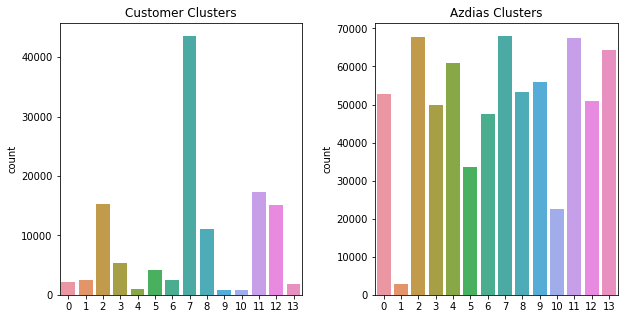

In [56]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_prediction, ax=axs[0])
sns.countplot(azdias_prediction, ax=axs[1])
axs[0].set_title("Customer Clusters")
axs[1].set_title("Azdias Clusters")
plt.show()


Based on the graphical output, it appears that there aren't too many clusters that are overrepresented in the customer data compared to the general population.  I could pick something but this seems overly hard to interpret.  Let me try something else.

In [57]:
unique_azdias, counts_azdias = np.unique(azdias_prediction, return_counts=True)
unique_customers, counts_customers = np.unique(customers_prediction, return_counts=True)

total_azdias = sum(counts_azdias)
total_customers = sum(counts_customers)

azdias_prop = [x/total_azdias for x in counts_azdias]
customers_prop = [x/total_customers for x in counts_customers]

diff_prop = [x - y for x, y in zip(customers_prop, azdias_prop)]



In [58]:
# THis will show the minimum and the value for the minimum (diff_prop).
minimum = min(diff_prop)
for x in range(len(diff_prop)):
    if minimum == diff_prop[x]:
        print(x)
print (minimum)

4
-0.0797805635492


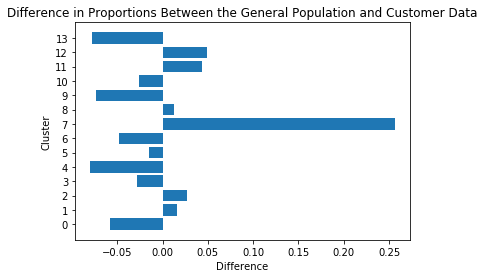

In [59]:
y_pos = np.arange(14)
plt.barh(y_pos, diff_prop)
plt.yticks(y_pos, range(14))
plt.ylabel("Cluster")
plt.xlabel("Difference")
plt.title("Difference in Proportions Between the General Population and Customer Data")
plt.show()

In [68]:
centroid_7  = scaler.inverse_transform(pca_30.inverse_transform(model_12.cluster_centers_[7]))
overrepresented_c = pd.Series(data = centroid_7, index = customers_clean.columns)
overrepresented_c


ALTERSKATEGORIE_GROB        3.322600
ANREDE_KZ                   1.099804
FINANZ_MINIMALIST           4.484719
FINANZ_SPARER               1.743496
FINANZ_VORSORGER            4.187082
FINANZ_ANLEGER              2.214299
FINANZ_UNAUFFAELLIGER       1.822802
FINANZ_HAUSBAUER            2.172127
GEBURTSJAHR              1186.557315
GREEN_AVANTGARDE            0.012188
HEALTH_TYP                  2.348222
RETOURTYP_BK_S              3.730637
SEMIO_SOZ                   4.682690
SEMIO_FAM                   4.622770
SEMIO_REL                   3.664959
SEMIO_MAT                   3.376674
SEMIO_VERT                  5.754959
SEMIO_LUST                  4.779146
SEMIO_ERL                   4.363154
SEMIO_KULT                  4.839593
SEMIO_RAT                   2.608028
SEMIO_KRIT                  3.628420
SEMIO_DOM                   3.212710
SEMIO_KAEM                  2.619901
SEMIO_PFLICHT               3.284557
SEMIO_TRADV                 2.937064
SOHO_KZ                     0.009482
A

In [71]:
centroid_4 = scaler.inverse_transform(pca_30.inverse_transform(model_12.cluster_centers_[4]))
underrepresented_c = pd.Series(data = centroid_4, index = customers_clean.columns)
underrepresented_c

ALTERSKATEGORIE_GROB        1.409329
ANREDE_KZ                   2.011418
FINANZ_MINIMALIST           1.200997
FINANZ_SPARER               4.265256
FINANZ_VORSORGER            2.197150
FINANZ_ANLEGER              4.111861
FINANZ_UNAUFFAELLIGER       3.620544
FINANZ_HAUSBAUER            4.170063
GEBURTSJAHR              1216.784079
GREEN_AVANTGARDE            0.053713
HEALTH_TYP                  2.124593
RETOURTYP_BK_S              2.395534
SEMIO_SOZ                   3.147595
SEMIO_FAM                   4.053849
SEMIO_REL                   5.627458
SEMIO_MAT                   5.342590
SEMIO_VERT                  2.155250
SEMIO_LUST                  2.518162
SEMIO_ERL                   3.961651
SEMIO_KULT                  4.406866
SEMIO_RAT                   6.572624
SEMIO_KRIT                  5.482471
SEMIO_DOM                   6.377037
SEMIO_KAEM                  6.176470
SEMIO_PFLICHT               6.606683
SEMIO_TRADV                 6.045008
SOHO_KZ                     0.008024
A

So what I did was to take the proportions of the azdias and the proprtions of the customers and find the difference between the two.  This will tell me which one is overrepresented...

So that means that Cluster4 if underrepresented and Cluster 7 is overrepresented.

Cluster7.
- ALTERSKATEGORIE_GROB is the 45-60 year old crowd and it is directly proprotional to the ability to be financially stable.  This group tends to be comfortable/prosperous (wealth = ~2.5).

Cluster 4.
- These people tend to be younger (< 30) and are not financially sound--they tend not to save and have low financial interest.  This group tends to be consumption oriented, middleclass.


I think I did this right....

### Discussion 3.3: Compare Customer Data to Demographics Data

See block right above this.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.